In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uvtools import dspec
import itertools
import scipy.special as sp
import copy
from matplotlib.colors import LogNorm
import healpy as hp
from pygsm import GlobalSkyModel
from pyuvsim import analyticbeam as ab
from hera_cal import frf
import os
import tqdm

In [2]:
def get_basename(gorder, dx, df, nf, rspace, f0):
        return f'HERA-III_dx{dx}_rspace{rspace}_G{gorder}_nf{nf}_df{df/1e3:.3f}kHz_f0{f0/1e6:.3f}'


In [3]:
def run_simulation(gorder=10, dx=2.0, df=100e3, nf=200, rspace=1., dynamic_range_db=-5.5, f0=100e6, output_dir='./'):
    golomb_dict = {0:[0], 1:[0,1], 2:[0,1,3], 
                   3:[0,1,4,6], 4:[0,1,4,6], 5:[0,1,4,9,11],
                   6:[0,1,4,10,12,17], 7:[0,1,4,10,18,23,25],
                   8:[0,1,4,9,15,22,32,34], 9:[0,1,5,12,25,27,35,41,44],
                   10:[0,1,6,10,23,26,34,41,53,55],
                   15:[0, 4, 20, 30, 57, 59, 62, 76, 100, 111, 123, 136, 144, 145, 151],
                   20:[0,1,8,11,68,77,94,116,121,156,158,
                       179,194,208,212,228,240,253,259, 283]}
    golomb_dict = {k:np.asarray(golomb_dict[k]) for k in golomb_dict}
    antpos = golomb_dict[gorder] * dx * rspace
    obs_freqs = np.linspace(f0, f0 + nf * df, nf)
    # write yaml file
    import yaml
    telescope_yaml_dict = {'beam_paths': {i: {'type': 'airy'} for i in range(len(antpos))}, 'diameter': dx, 
                           'telescope_location': '(-30.721527777777847, 21.428305555555557, 1073.0000000046566)',
                           'telescope_name': 'HERA'}
    telescope_yaml_name = os.path.join(output_dir, f'airy_config_dx{dx}.yaml')
    with open(telescope_yaml_name, 'w') as telescope_yaml_file:
        yaml.safe_dump(telescope_yaml_dict, telescope_yaml_file)
    # write csv file.
    csv_name =  os.path.join(output_dir, f'layout_dx{dx}_rspace{rspace}_G{gorder}.csv')
    lines = []
    lines.append('Name\tNumber\tBeamID\tE    \tN    \tU\n')
    for i, x  in enumerate(antpos):
        lines.append(f'ANT{i}\t{i}\t{i}\t{x:.4f}\t{0:.4f}\t{0:.4f}\n')
    with open(csv_name, 'w') as csv_file:
        csv_file.writelines(lines)
    # generate obs param dict and csv file
    obs_param_dict = {'freq':{'Nfreqs': int(nf), 'bandwidth': float(nf * df), 'start_freq': float(obs_freqs[0])},
                      'telescope': {'array_layout': csv_name,
                                    'telescope_config_name': telescope_yaml_name},
                      'time': {'Ntimes': 1, 'duration_days': 0.0012731478148148147, 
                               'integration_time': 11.0, 'start_time': 2457458.1738949567},
                      'polarization_array': [-5]}
    basename = get_basename(gorder, dx, df, nf, rspace, f0)
    obs_param_yaml_name = os.path.join(output_dir, f'{basename}.yaml')
    with open(obs_param_yaml_name, 'w') as obs_param_yaml:
        yaml.safe_dump(obs_param_dict, obs_param_yaml)
    # generate GSM cube
    gsm = GlobalSkyModel(freq_unit='Hz')
    NSIDE_GSM = 256
    NPIX_GSM = hp.nside2npix(NSIDE_GSM)
    gsmcube = np.zeros((nf, NPIX_GSM))
    rot=hp.rotator.Rotator(coord=['G', 'C'])
    for fnum,f in enumerate(obs_freqs):
        mapslice = gsm.generate(f)
        mapslice = hp.ud_grade(mapslice, NSIDE_GSM)
        # convert from galactic to celestial
        gsmcube[fnum] = rot.rotate_map_pixel(mapslice)
    gsmcube = np.array(gsmcube)
    gsmcube = 2 * gsmcube * np.pi * 4 / NPIX_GSM * 1.4e-23 / 1e-26 / (3e8 / obs_freqs[:, None])**2\
            / hp.nside2pixarea(NSIDE_GSM)
    from hera_sim.visibilities import vis_cpu
    # define eor cube with random noise.
    eorcube = np.abs(np.random.randn(*gsmcube.shape))
    eorcube *= np.std(gsmcube) / np.std(eorcube) * 10. ** (dynamic_range_db)
    from pyuvsim.simsetup import initialize_uvdata_from_params, _complete_uvdata
    uvdata, beams, beam_ids = initialize_uvdata_from_params(obs_param_yaml_name)
    _complete_uvdata(uvdata, inplace=True)
    beam_ids = list(beam_ids.values())
    beams.set_obj_mode()
    eor_simulator = vis_cpu.VisCPU(uvdata=copy.deepcopy(uvdata), sky_freqs=obs_freqs, beams=beams, beam_ids=beam_ids, sky_intensity=eorcube)
    eor_vis = eor_simulator.simulate()
    gsm_simulator = vis_cpu.VisCPU(uvdata=copy.deepcopy(uvdata), sky_freqs=obs_freqs, beams=beams, beam_ids=beam_ids, sky_intensity=gsmcube)
    gsm_vis = gsm_simulator.simulate()
    # write uvdata files.
    gsm_simulator.uvdata.write_uvh5(basename + '_gsm.uvh5', clobber=True)
    eor_simulator.uvdata.write_uvh5(basename + f'_eor_{dynamic_range_db:.1f}dB.uvh5', clobber=True)
    return gsm_simulator.uvdata, eor_simulator.uvdata

In [4]:
def fft_arrange_wedge(uvd, tind=0, polind=0, window='bh', min_bl=0.1, filtermatrix=None, include_autos=False):
    """
    generate an (NF x NBL) array with baselines arranged in ascending length
    """
    uvd = copy.deepcopy(uvd)
    if not include_autos:
        uvd.select(bls=[bl for bl in uvd.get_antpairs() if bl[0] != bl[1]])
    data_inds = np.where(uvd.time_array == np.unique(uvd.time_array)[tind])[0]
    data = uvd.data_array[data_inds, 0, :, polind].reshape(len(data_inds), uvd.Nfreqs)
    if filtermatrix is not None:
        data = (filtermatrix @ (data.reshape(len(data_inds) * uvd.Nfreqs, order='F'))).reshape(len(data_inds), uvd.Nfreqs, order='F')
    bl_lens = np.linalg.norm(uvd.uvw_array[data_inds], axis=1)
    sorted_lens = np.argsort(bl_lens)
    data = data[sorted_lens, :]
    bl_lens = bl_lens[sorted_lens]
    data = data[bl_lens > min_bl]
    bl_lens = bl_lens[bl_lens > min_bl]
    wf = dspec.gen_window(window, uvd.Nfreqs)
    delays = 1e9 * np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs, np.mean(np.diff(uvd.freq_array))))
    return bl_lens, delays, np.fft.fftshift(np.fft.fft(np.fft.fftshift(wf[None, :] * data, axes=1), axis=1), axes=1)

In [6]:
def cov_mat_simple(uvd, eta_max=0.0, order_by_u=False, per_baseline=True):
    uvd = copy.deepcopy(uvd)
    # only works on a 1d array.
    data_inds = np.where(uvd.time_array == np.unique(uvd.time_array)[0])[0]
    for uindex in [1, 2]:
        assert np.allclose(uvd.uvw_array[data_inds, uindex], 0.0)
    uvals = np.outer(uvd.uvw_array[data_inds, 0], uvd.freq_array[0] / 3e8).flatten('F')
    nuvals = np.outer(np.ones(uvd.Nbls), uvd.freq_array[0]).flatten('F')
    if order_by_u:
        uordering = np.argsort(uvals)
        uvals = uvals[uordering]
        nuvals = nuvals[uordering]
    u_x, u_y = np.meshgrid(uvals, uvals)
    nu_x, nu_y = np.meshgrid(nuvals, nuvals)
    covmat = np.sinc(2 * (u_x - u_y)) * np.sinc(2 * eta_max * (nu_x - nu_y))
    if per_baseline:
        covmat[~np.isclose(u_x / nu_x * 3e8, u_y / nu_y * 3e8)] = 0.0
    return covmat

def filter_mat_simple(uvd, eta_max, order_by_u=False, tol=1e-8, per_baseline=True):
    cmat_simple = cov_mat_simple(uvd, eta_max=eta_max, order_by_u=order_by_u, per_baseline=per_baseline)
    cmat_simple = cmat_simple / tol + np.identity(cmat_simple.shape[0])
    return np.linalg.pinv(cmat_simple)

def filter_data(uvd, eta_max, order_by_u=False, tol=1e-8, per_baseline=True):
    uvd = copy.deepcopy(uvd)
    if not per_baseline:
        filter_matrix = filter_mat_simple(uvd, eta_max, order_by_u, tol, per_baseline=False)
        for time in np.unique(uvd.time_array):
            data_inds = np.where(uvd.time_array == time)[0]
            for pind in range(uvd.data_array.shape[-1]):
                data = uvd.data_array[data_inds, 0, :, pind].squeeze()
                uvd.data_array[data_inds, 0, :, pind] = \
                (filter_matrix @\
                 (data.reshape(len(data_inds)\
                  * uvd.Nfreqs, order='F'))).reshape(len(data_inds), uvd.Nfreqs, order='F')
    else:
        cache = {}
        for time in np.unique(uvd.time_array):
            data_inds = np.where(uvd.time_array == time)[0]
            for pind in range(uvd.data_array.shape[-1]):
                for rownum in range(uvd.data_array[data_inds, 0, :, pind].squeeze().shape[0]):
                    drow = uvd.data_array[data_inds, 0, :, pind][rownum].squeeze()
                    fw = eta_max + np.linalg.norm(uvd.uvw_array[data_inds[rownum]]) / 3e8
                    filtered\
                    = dspec.dayenu_filter(x=uvd.freq_array[0], data=drow, 
                                          wgts=np.ones(uvd.Nfreqs), 
                                          cache=cache, filter_centers=[0.0], 
                                          filter_half_widths=[fw], 
                                          filter_dimensions=[0],
                                          filter_factors=[tol])[0]
                    uvd.data_array[data_inds[rownum], 0, :, pind] = filtered
                
    return uvd



In [7]:
def process_configuration(gorder=10, dx=2.0, df=100e3, nf=200, rspace=1., 
                          dynamic_range_db=-5.5, tol=1e-11, f0=100e6, output_dir='./', 
                          buffer_multiplier=1.0, skip_existing=True):
    basename = get_basename(gorder, dx, df, nf, rspace, f0)
    filtered_pbl_file = os.path.join(output_dir, basename + f'_bmult{buffer_multiplier:.2f}_tol{tol:.1e}_pbl.uvh5')
    filtered_ibl_file = os.path.join(output_dir, basename + f'_bmult{buffer_multiplier:.2f}_tol{tol:.1e}_ibl.uvh5')
    if (not os.path.exists(filtered_pbl_file) or not os.path.exists(filtered_ibl_file)) or not skip_existing:
        uvd_eor_name = os.path.join(output_dir, basename + '_eor.uvh5')
        uvd_gsm_name = os.path.join(output_dir, basename + '_gsm.uvh5')
        if os.path.exists(uvd_eor_name) and os.path.exists(uvd_gsm_name):
            uvd_eor = UVData()
            uvd_eor.read_uvh5(uvd_eor_name)
            uvd_gsm = UVData()
            uvd_gsm.read_uvh5(uvd_gsm_name)
        else:
            uvd_eor, uvd_gsm = run_simulation(gorder=gorder, 
                                              dx=dx, df=df, nf=nf, rspace=rspace, 
                                              dynamic_range_db=dynamic_range_db, output_dir=output_dir)
        uvd_total = copy.deepcopy(uvd_eor)
        uvd_total.data_array = uvd_eor.data_array + uvd_gsm.data_array
        uvd_filtered_pbl = filter_data(uvd_total, eta_max=2 / 3e8 * buffer_multiplier, tol=tol)
        uvd_filtered_ibl = filter_data(uvd_total, eta_max=2 / 3e8 * buffer_multiplier, tol=tol, per_baseline=False)
        uvd_filtered_pbl.write_uvh5(filtered_pbl_file, clobber=True)
        uvd_filtered_ibl.write_uvh5(filtered_ibl_file, clobber=True)

In [8]:
r_spaces = [1, 1.5, 2.]
dxs = [2.0, 4.0, 8.0, 14.0]
nfs = [100, 200, 400]
gorders = [10, 15]
dfs = [100e3, 200e3]
param_combinations = []

for rspace in r_spaces:
    for dx in dxs:
        for nf in nfs:
            for df in dfs:
                for gorder in gorders:
                    param_combinations.append({'rspace':rspace, 'dx':dx, 'nf':nf, 'df':df, 'gorder':gorder})


In [9]:
import imp
imp.reload(dspec)

<module 'uvtools.dspec' from '/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/uvtools/dspec.py'>

In [10]:
os.mkdir('./param_sweep')

In [ ]:
for params in tqdm.tqdm(param_combinations):
    try:
        process_configuration(output_dir='./param_sweep/',**params)
    except:
        print(f'Failed {params}')

  0%|          | 0/144 [00:00<?, ?it/s]/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regulari

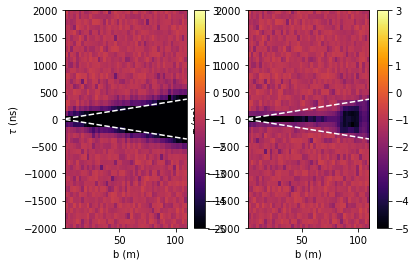

In [31]:
fix, axarr = plt.subplots(1, 2)
for i, uvd_filtered in enumerate([uvd_filtered_pbl, uvd_filtered_ibl]):
    plt.sca(axarr[i])
    x, y, ctot = fft_arrange_wedge(uvd_filtered, window='none')

    plt.imshow(np.log10(np.abs(ctot).T), extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-5, vmax=3, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    plt.ylim(-2000, 2000)